<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/2-Advance/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
# ## install finrl library
!pip install wrds
!pip install swig
!pip install -q condacolab
import condacolab
condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 56.9 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.9
    Uninstalling SQLAlchemy-2.0.9:
      Successfully uninstalled SQLAlchemy-2.0.9
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.5 MB/s eta 0:00:00
⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:12
🔁 Restarting kernel...
Selecting previously unselected package libgl1-mesa-glx:amd64.
(Reading database ... 122349 files and directories currently installed.)
Preparing to unpack .../libgl1-mesa-


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

In [1]:
!pip install pandas==1.5.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 28.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.0
    Uninstalling pandas-2.0.0:
      Successfully uninstalled pandas-2.0.0


<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
tickers = ['BAJAJ-AUTO.NS',	
'TITAN.NS',	
'TATASTEEL.NS',	
'NESTLEIND.NS',	
'BRITANNIA.NS',	
'TATACONSUM.NS',
'CIPLA.NS',	
'ULTRACEMCO.NS',	
'RELIANCE.NS',	
'ITC.NS',	
'BHARTIARTL.NS',	
'MARUTI.NS',	
'ONGC.NS',	
'BAJFINANCE.NS',	
'COALINDIA.NS',	
'ICICIBANK.NS',	
'WIPRO.NS',	
'HINDALCO.NS',	
'HEROMOTOCO.NS',	
'ADANIENT.NS',	
'LT.NS',	
'KOTAKBANK.NS',	
'BAJAJFINSV.NS',	
'NTPC.NS',	 
'TCS.NS',	
'APOLLOHOSP.NS',	
'HDFCLIFE.NS',	
'INDUSINDBK.NS',	
'DRREDDY.NS',					
'TECHM.NS']	


In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [5]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [6]:
print(tickers)

['BAJAJ-AUTO.NS', 'TITAN.NS', 'TATASTEEL.NS', 'NESTLEIND.NS', 'BRITANNIA.NS', 'TATACONSUM.NS', 'CIPLA.NS', 'ULTRACEMCO.NS', 'RELIANCE.NS', 'ITC.NS', 'BHARTIARTL.NS', 'MARUTI.NS', 'ONGC.NS', 'BAJFINANCE.NS', 'COALINDIA.NS', 'ICICIBANK.NS', 'WIPRO.NS', 'HINDALCO.NS', 'HEROMOTOCO.NS', 'ADANIENT.NS', 'LT.NS', 'KOTAKBANK.NS', 'BAJAJFINSV.NS', 'NTPC.NS', 'TCS.NS', 'APOLLOHOSP.NS', 'HDFCLIFE.NS', 'INDUSINDBK.NS', 'DRREDDY.NS', 'TECHM.NS']


In [7]:
# TRAIN_START_DATE = '2009-04-01'
# TRAIN_END_DATE = '2021-01-01'
# TEST_START_DATE = '2021-01-01'
# TEST_END_DATE = '2022-06-01'

TRAIN_START_DATE = '2005-01-01'
TRAIN_END_DATE = '2021-10-01'
TEST_START_DATE = '2021-10-01'
TEST_END_DATE = '2023-04-01'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = tickers).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [8]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2005-01-03,5.962399,6.054364,5.901089,4.469342,6912918,ADANIENT.NS,0
1,2005-01-03,126.000000,131.000000,126.000000,115.370979,164838,APOLLOHOSP.NS,0
2,2005-01-03,287.250000,289.950012,281.299988,190.725174,778286,BAJAJ-AUTO.NS,0
3,2005-01-03,1149.000000,1159.800049,1125.199951,1121.040161,389100,BAJAJFINSV.NS,0
4,2005-01-03,11.490891,11.703667,11.322807,9.849683,179573,BAJFINANCE.NS,0


In [9]:
df.tail()

,date,open,high,low,close,volume,tic,day
130107,2023-03-31,3189.949951,3213.000000,3152.000000,3205.899902,2382581,TCS.NS,4
130108,2023-03-31,1095.000000,1106.000000,1091.449951,1101.849976,2281085,TECHM.NS,4
130109,2023-03-31,2526.949951,2536.750000,2500.000000,2514.899902,848456,TITAN.NS,4
130110,2023-03-31,7575.100098,7644.299805,7547.049805,7622.149902,378456,ULTRACEMCO.NS,4
130111,2023-03-31,363.350006,365.750000,361.299988,365.250000,3957106,WIPRO.NS,4


In [10]:
df.shape

(130112, 8)

In [11]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2005-01-03,5.962399,6.054364,5.901089,4.469342,6912918,ADANIENT.NS,0
1,2005-01-03,126.000000,131.000000,126.000000,115.370979,164838,APOLLOHOSP.NS,0
2,2005-01-03,287.250000,289.950012,281.299988,190.725174,778286,BAJAJ-AUTO.NS,0
3,2005-01-03,1149.000000,1159.800049,1125.199951,1121.040161,389100,BAJAJFINSV.NS,0
4,2005-01-03,11.490891,11.703667,11.322807,9.849683,179573,BAJFINANCE.NS,0


In [12]:
len(df.tic.unique())

30

In [13]:
df.tic.value_counts()

ADANIENT.NS      4505
APOLLOHOSP.NS    4505
WIPRO.NS         4505
ULTRACEMCO.NS    4505
TITAN.NS         4505
TCS.NS           4505
TATASTEEL.NS     4505
TATACONSUM.NS    4505
RELIANCE.NS      4505
ONGC.NS          4505
NTPC.NS          4505
NESTLEIND.NS     4505
MARUTI.NS        4505
LT.NS            4505
ICICIBANK.NS     4505
HINDALCO.NS      4505
HEROMOTOCO.NS    4505
DRREDDY.NS       4505
CIPLA.NS         4505
BRITANNIA.NS     4505
BHARTIARTL.NS    4505
BAJFINANCE.NS    4505
BAJAJ-AUTO.NS    4505
KOTAKBANK.NS     4504
ITC.NS           4504
BAJAJFINSV.NS    4504
INDUSINDBK.NS    4503
TECHM.NS         4094
COALINDIA.NS     3060
HDFCLIFE.NS      1328
Name: tic, dtype: int64

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [14]:
#  INDICATORS = ['macd',
#                'rsi_30',
#                'cci_30',
#                'dx_30']

In [15]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [16]:
processed.sample(5)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
49198,2013-08-28,886.000000,886.000000,850.000000,828.169922,190054,APOLLOHOSP.NS,2,-21.035497,966.344123,812.381518,43.888678,-164.158593,38.950974,906.459336,921.836125,72.619907
5436,2005-12-13,859.000000,859.000000,848.049988,492.146942,255413,HEROMOTOCO.NS,1,11.772092,503.127114,456.677833,61.890439,88.308031,38.365378,464.643224,439.460162,0.000000
4635,2005-10-20,544.500000,551.000000,526.200012,473.757263,782324,MARUTI.NS,3,3.350617,523.469475,466.435884,52.239436,-54.760907,15.121759,488.657245,457.054214,0.000000
65169,2016-06-28,209.636368,212.909088,209.090912,204.217789,11302737,ICICIBANK.NS,1,0.610252,220.238502,200.145825,50.444655,-51.190786,21.931825,206.676375,202.723598,19.564551
76282,2018-06-11,134.583328,135.500000,134.375000,101.412392,4838494,NTPC.NS,0,-1.292585,106.860338,100.205904,43.139442,-124.611443,15.913273,104.710255,105.902021,22.680257


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [17]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 23, State Space: 231


In [18]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [19]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)



In [20]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 10_000, 
                 'ppo' : 10_000, 
                 'ddpg' : 10_000
                 }

In [21]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  120.32521340598709
======Model training from:  2005-01-01 to  2021-10-04
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/a2c/a2c_126_1
---------------------------------------
| time/                 |             |
|    fps                | 44          |
|    iterations         | 100         |
|    time_elapsed       | 11          |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -32.7       |
|    explained_variance | 0.109       |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | 98          |
|    reward             | -0.38942474 |
|    std                | 1           |
|    value_loss         | 12.3        |
---------------------------------------
-------------------------------------
| time/                 |        

In [22]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2021-10-04,2022-01-04,DDPG,-0.09936,-0.003758,0.146671
1,189,2022-01-04,2022-04-06,DDPG,-0.215461,-0.300133,-0.066381
2,252,2022-04-06,2022-07-07,PPO,-0.273669,0.061958,-0.170669
3,315,2022-07-07,2022-10-10,DDPG,0.34739,0.188618,0.365557


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [23]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [24]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  0.5825420055077339


In [25]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1.000000e+06,2022-01-04,NaN,2022-01-04
1,1.008050e+06,2022-01-05,0.008050,2022-01-05
2,1.016503e+06,2022-01-06,0.008385,2022-01-06
3,1.017695e+06,2022-01-07,0.001172,2022-01-07
4,1.040814e+06,2022-01-10,0.022717,2022-01-10


<Axes: >

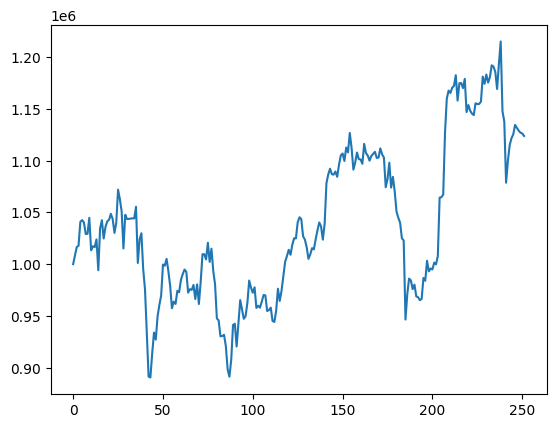

In [26]:
%matplotlib inline
df_account_value.account_value.plot()

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [27]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.123854
Cumulative returns     0.123854
Annual volatility      0.258972
Sharpe ratio           0.582542
Calmar ratio           0.731434
Stability              0.383231
Max drawdown          -0.169331
Omega ratio            1.111970
Sortino ratio          0.801024
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.978742
Daily value at risk   -0.032029
dtype: float64


In [28]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (253, 8)
Annual return         -0.104759
Cumulative returns    -0.105152
Annual volatility      0.197907
Sharpe ratio          -0.462610
Calmar ratio          -0.477463
Stability              0.218181
Max drawdown          -0.219408
Omega ratio            0.926636
Sortino ratio         -0.643031
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.013273
Daily value at risk   -0.025297
dtype: float64


In [29]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji+.csv")

df_account_value.to_csv('df_account_value.csv')


df_dji:             date             dji
0    2022-01-04  1000000.000000
1    2022-01-05   989333.075745
2    2022-01-06   984696.057940
3    2022-01-07   984565.388384
4    2022-01-10   980141.730294
..          ...             ...
247  2023-01-02   893370.244918
248  2023-01-03   902747.775911
249  2023-01-04   900749.094283
250  2023-01-05   900453.469006
251  2023-01-06   904078.461178

[252 rows x 2 columns]
df_dji:                         dji
date                      
2022-01-04  1000000.000000
2022-01-05   989333.075745
2022-01-06   984696.057940
2022-01-07   984565.388384
2022-01-10   980141.730294
...                    ...
2023-01-02   893370.244918
2023-01-03   902747.775911
2023-01-04   900749.094283
2023-01-05   900453.469006
2023-01-06   904078.461178

[252 rows x 1 columns]


<a id='6.2'></a>
## 7.2 BackTestPlot

df_result_ensemble.columns:  Index(['ensemble'], dtype='object')
df_trade_date:         datadate
0    2021-10-04
1    2021-10-05
2    2021-10-06
3    2021-10-07
4    2021-10-08
..          ...
367  2023-03-24
368  2023-03-27
369  2023-03-28
370  2023-03-29
371  2023-03-31

[372 rows x 1 columns]
df_result_ensemble:                  ensemble
date                    
2022-01-04  1.000000e+06
2022-01-05  1.008050e+06
2022-01-06  1.016503e+06
2022-01-07  1.017695e+06
2022-01-10  1.040814e+06
...                  ...
2023-01-02  1.131678e+06
2023-01-03  1.129109e+06
2023-01-04  1.127069e+06
2023-01-05  1.126281e+06
2023-01-06  1.123854e+06

[252 rows x 1 columns]
==============Compare to DJIA===========
result:                  ensemble             dji
date                                    
2022-01-04  1.000000e+06  1000000.000000
2022-01-05  1.008050e+06   989333.075745
2022-01-06  1.016503e+06   984696.057940
2022-01-07  1.017695e+06   984565.388384
2022-01-10  1.040814e+06   980141.730

<Figure size 1500x500 with 0 Axes>

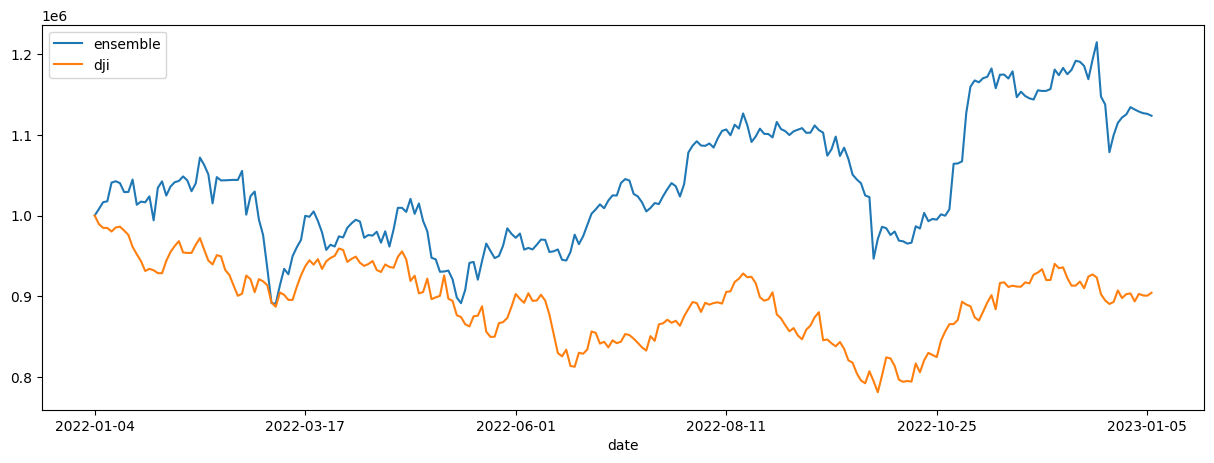

In [30]:


# print("==============Compare to DJIA===========")
# %matplotlib inline
# # S&P 500: ^GSPC
# # Dow Jones Index: ^DJI
# # NASDAQ 100: ^NDX
# backtest_plot(df_account_value, 
#               baseline_ticker = '^DJI', 
#               baseline_start = df_account_value.loc[0,'date'],
#               baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])
df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

print("df_result_ensemble.columns: ", df_result_ensemble.columns)

# df_result_ensemble.drop(df_result_ensemble.columns[0], axis = 1)
print("df_trade_date: ", df_trade_date)
# df_result_ensemble['date'] = df_trade_date['datadate']
# df_result_ensemble['account_value'] = df_account_value['account_value']
df_result_ensemble.to_csv("df_result_ensemble.csv")
print("df_result_ensemble: ", df_result_ensemble)
print("==============Compare to DJIA===========")
result = pd.DataFrame()
# result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)
# result = pd.merge(result, df_dji, left_index=True, right_index=True)
result = pd.merge(df_result_ensemble, df_dji, left_index=True, right_index=True)
print("result: ", result)
result.to_csv("result.csv")
result.columns = ['ensemble', 'dji']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
!cp -r "/content/" "/content/drive/MyDrive/RL_India"

cp: cannot open '/content/drive/MyDrive/Report.gdoc' for reading: Operation not supported
cp: cannot open '/content/drive/MyDrive/Behavioral Economics- ECON F345 Review Report Project.gdoc' for reading: Operation not supported
cp: cannot open '/content/drive/MyDrive/Behavioral Economics Report.gslides' for reading: Operation not supported
cp: cannot open '/content/drive/MyDrive/Celebal Report.gdoc' for reading: Operation not supported
cp: cannot open '/content/drive/MyDrive/No Objection.gdoc' for reading: Operation not supported
cp: cannot open '/content/drive/MyDrive/Logic Class (2021-09-22 at 03:36 GMT-7)' for reading: No such file or directory
cp: cannot open '/content/drive/MyDrive/IED Presentation.gslides' for reading: Operation not supported
cp: cannot open '/content/drive/MyDrive/DD_Lab 9_Decoders, multiplexers_Updated.gslides' for reading: Operation not supported
cp: cannot open '/content/drive/MyDrive/ManualOracleDBInstallation_2022.gdoc' for reading: Operation not supported
c

In [ ]:
!du -h /content

72K	/content/.config/logs/2023.04.13
76K	/content/.config/logs
8.0K	/content/.config/configurations
108K	/content/.config
612K	/content/results
31M	/content/trained_models
5.6G	/content/drive/.shortcut-targets-by-id/1XGTHgyifMgGGSq3gx5tR2DCSyJOWVQRO/ECON F243 (Lectures & Tutorials) - 2020-21
5.6G	/content/drive/.shortcut-targets-by-id/1XGTHgyifMgGGSq3gx5tR2DCSyJOWVQRO
5.6G	/content/drive/.shortcut-targets-by-id
4.0K	/content/drive/.file-revisions-by-id
4.0K	/content/drive/Shareddrives
8.0M	/content/drive/MyDrive/Classroom/MATH F113 8
1.3M	/content/drive/MyDrive/Classroom/MATH F112 T3
4.0K	/content/drive/MyDrive/Classroom/EVS_Test1_September16th
4.0K	/content/drive/MyDrive/Classroom/MATH F211 (MATHEMATICS - III) L4
4.0K	/content/drive/MyDrive/Classroom/BITS F225 Environmental Studies Environmental Studies
4.0K	/content/drive/MyDrive/Classroom/DRM-Sem-1-2020-21
4.0K	/content/drive/MyDrive/Classroom/EVS-Test-2
4.0K	/content/drive/MyDrive/Classroom/Test3_EVS
2.0M	/content/drive/MyDrive/Cla